# Spark Machine learning 

### Learning goals:

- locate and explore the Spark.ML documentation
- code along a text classification problem using four different ml algorithms, a data prep pipeline, and gridsearch to fine tune a model

# Spark context and concepts review
![sparkler](https://images.pexels.com/photos/285173/pexels-photo-285173.jpeg?auto=compress&cs=tinysrgb&dpr=2&h=750&w=1260)

# The story of Spark (a timeline)

|<p align="left justify">Date</p>|<p align="left justify">Product</p>|<p align="left justify">Update</p>|
|:----|:-----|:-----|
| 2002 | Hadoop | <p align="left justify">Doug Cutting starts `Apache Nutch` researching sort/merge processing</p> |
| 2006 | Hadoop |  <p align="left justify">Leaves `Nutch` and joins `Yahoo`, renaming the project `Hadoop` </p>|
| 2008 | Hadoop |  <p align="left justify">`Hadoop` was made `Apache’s` top level project </p> |
| Jan 2008 | Hadoop |  <p align="left justify">v 0.10.1 released </p>|
| 2009 | Spark | <p align="left justify">started as a research project at the UC Berkeley AMPLab  </p>|
| 2010 | Spark |  <p align="left justify">open sourced </p>|
| Sept 2012 | Spark |  <p align="left justify">0.6.0 released </p>|
| 2013 | Spark |  <p align="left justify">moved to the `Apache` Software Foundation </p>|
| Feb 2013| Spark |  <p align="left justify">Spark 0.7 adds a Python API called `PySpark` </p>|
| Sept 2013 | Spark | <p align="left justify">0.8.0 introduces `MLlib` </p>|
| 2013 | Databricks |  <p align="left justify">Original Spark research team at UC Berkeley found Databricks</p> |
| May 2014 |Spark |  <p align="left justify">v 1.0 introduces Spark SQL, for loading and manipulating structured data in Spark</p>|
| Sept 2014 | Spark|  <p align="left justify">v 1.1.0 provided support for registering Python lambda funtions as UDFs</p>|
|Mar 2015 | Spark | <p align="left justify"> v 1.3.0 brings a new DataFrame API</p> |
| Jun 2015 | Spark | <p align="left justify"> v 1.4.0 brings an R API to Spark</p> |
| 2015 | Databricks | <p align="left justify"> The Databricks Apache Spark cloud platform goes public</p> |
| Jan 2016|  Spark | <p align="left justify"> v 1.6.0 brings a new Dataset API <br> - A new Spark API, similar to RDDs, that allows users to work with custom objects and lambda functions while still gaining the benefits of the Spark SQL execution engine.</p> |
| Jul 2016 | Spark | <p align="left justify"> v 2.0.0 **big update**! <Br> - Unifying DataFrame and Dataset: In Scala and Java, DataFrame and Dataset have been unified, i.e. DataFrame is just a type alias for Dataset of Row. In Python and R, given the lack of type safety, DataFrame is the main programming interface. <br> - SparkSession: new entry point that replaces the old SQLContext<br>- Native CSV data source, based on Databricks’ spark-csv module<br>- MLlib - The DataFrame-based API is now the primary API. The RDD-based API is entering maintenance mode </p> |
| 2016 | Databricks | <p align="left justify"> Databricks Launches Free Community Edition As Companion To Free Online Spark Courses </p>|
| Jul 2017| Spark | <p align="left justify"> v 2.2.0 drops support for Python 2.6 |
| Nov 2018 | Spark | <p align="left justify"> v 2.4.0<br> - This release adds Barrier Execution Mode for better integration with deep learning frameworks<br> - more integration between pandas UDF and spark DataFrames </p>|


# Machine learning in Spark


### Create spark context

In [2]:
import pyspark
spark = pyspark.sql.SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [4]:
spark

In [5]:
sc

<SparkContext master=local[2] appName=pyspark-shell>

### Read in our dataset of articles

In [8]:
bbc = spark.read.csv(path='bbc-text.csv',sep=',',encoding='UTF-8', header=True,inferSchema=True)

In [9]:
def show(df, n=5):
    return df.limit(n).toPandas()

### Do some basic data exploration

In [7]:
bbc.columns

['category', 'text']

In [10]:
bbc.dtypes

[('category', 'string'), ('text', 'string')]

In [11]:
bbc.printSchema()

root
 |-- category: string (nullable = true)
 |-- text: string (nullable = true)



In [12]:
bbc.limit(10).toPandas()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
5,politics,howard hits back at mongrel jibe michael howar...
6,politics,blair prepares to name poll date tony blair is...
7,sport,henman hopes ended in dubai third seed tim hen...
8,sport,wilkinson fit to face edinburgh england captai...
9,entertainment,last star wars not for children the sixth an...


In [13]:
bbc.count()

2225

In [12]:
bbc.groupBy('category').count().show()

+-------------+-----+
|     category|count|
+-------------+-----+
|        sport|  511|
|     politics|  417|
|entertainment|  386|
|     business|  510|
|         tech|  401|
+-------------+-----+



In [14]:
# Create a new column of target "politics"
from pyspark.sql.functions import when, col
bbc = bbc.withColumn("label", \
                           (when(col("category").like("%politics%"), 1) \
                           .otherwise(0)))

In [15]:
# drop original target column
bbc = bbc.drop(bbc.category)

In [16]:
show(bbc,10)

,text,label
0,tv future in the hands of viewers with home th...,0
1,worldcom boss left books alone former worldc...,0
2,tigers wary of farrell gamble leicester say ...,0
3,yeading face newcastle in fa cup premiership s...,0
4,ocean s twelve raids box office ocean s twelve...,0
5,howard hits back at mongrel jibe michael howar...,1
6,blair prepares to name poll date tony blair is...,1
7,henman hopes ended in dubai third seed tim hen...,0
8,wilkinson fit to face edinburgh england captai...,0
9,last star wars not for children the sixth an...,0


## Machine Learning in Spark

Spark's [documentation](https://spark.apache.org/docs/2.2.0/ml-guide.html#mllib-main-guide) is fairly straight forward!  Let's take a look. It shouldn't look *too* different than `sklearn`

### Data prep pipeline

In [17]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer


# regular expression tokenizer
regexTokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\\W")

# stop words
add_stopwords = ["http","https","amp","rt","t","c","can"] # standard stop words
stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(add_stopwords)

# bag of words count
countVectors = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=10000, minDF=5)


In [18]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors])

# Fit the pipeline to training documents.
pipelineFit = pipeline.fit(bbc)
dataset = pipelineFit.transform(bbc)

In [19]:
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 1562
Test Dataset Count: 663


### Logistic Regression

In [20]:
from pyspark.ml.classification import LogisticRegression
# Build the model
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0, family = "binomial")

# Train model with Training Data
lrModel = lr.fit(trainingData)

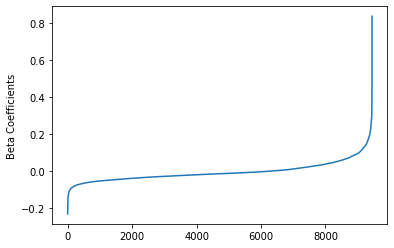

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

beta = np.sort(lrModel.coefficients)

plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

### Summary has many components one can call

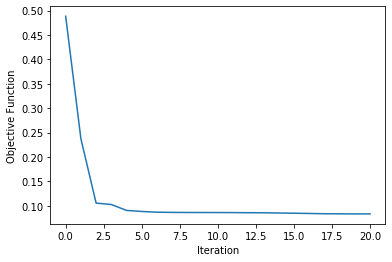

In [26]:
# Extract the summary from the returned LogisticRegressionModel instance trained
trainingSummary = lrModel.summary

import matplotlib.pyplot as plt
# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
plt.plot(objectiveHistory)
plt.ylabel('Objective Function')
plt.xlabel('Iteration')
plt.show()

areaUnderROC: 0.9999258547229217


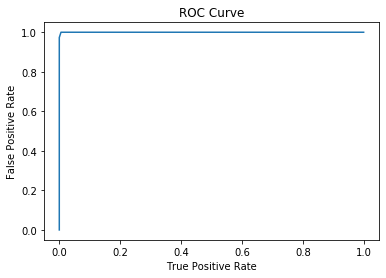

In [22]:
# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

#trainingSummary.roc.show(n=10, truncate=15)
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

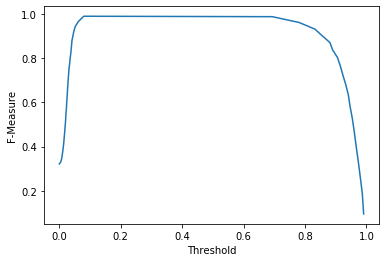

In [24]:
# Set the model threshold to maximize F-Measure
#trainingSummary.fMeasureByThreshold.show(n=10, truncate = 15)
f = trainingSummary.fMeasureByThreshold.toPandas()
plt.plot(f['threshold'],f['F-Measure'])
plt.ylabel('F-Measure')
plt.xlabel('Threshold')
plt.show()

### Evaluate on test data

In [23]:
# Make predictions on test data using the transform() method.
# LogisticRegression.transform() will only use the 'features' column.
predictions = lrModel.transform(testData)

predictions.select("text","probability").show(n=20, truncate=40)

+----------------------------------------+----------------------------------------+
|                                    text|                             probability|
+----------------------------------------+----------------------------------------+
|2d metal slug offers retro fun like s...|[0.9793502775263708,0.020649722473629...|
|a year to remember for irish there us...|[0.9979977191963888,0.002002280803611...|
|a-listers flock to gervais sitcom hol...|[0.9843819663537455,0.015618033646254...|
|aaliyah claim dismissed by court late...| [0.956877735111717,0.04312226488828297]|
|actor foxx sees globe nominations us ...|[0.9576062640365329,0.04239373596346711]|
|ad firm wpp s profits surge 15% uk ad...|[0.981338715231336,0.018661284768664077]|
|ad sales boost time warner profit qua...|[0.9980324106505575,0.001967589349442...|
|adventure tale tops awards young book...|[0.9741037986810397,0.025896201318960...|
|air china in $1bn london listing chin...|[0.9937250974462042,0.006274902553

#### Prediction object is a dataframe
with some options

In [30]:
predictions.printSchema()

root
 |-- text: string (nullable = true)
 |-- label: integer (nullable = false)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [31]:
predictions.filter(predictions['prediction'] == 1) \
    .select("text","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 20, truncate = 30)

+------------------------------+------------------------------+-----+----------+
|                          text|                   probability|label|prediction|
+------------------------------+------------------------------+-----+----------+
|nuclear strike  key terror ...|[0.46298199442594773,0.5370...|    1|       1.0|
|tory expert denies defeat w...|[0.4561989512341065,0.54380...|    1|       1.0|
|brown calls for £5.5bn aids...|[0.44109882893385294,0.5589...|    1|       1.0|
|peace demo appeal rejected ...|[0.41344377475773847,0.5865...|    1|       1.0|
|baa support ahead of court ...|[0.3879597042542834,0.61204...|    1|       1.0|
|kennedy predicts bigger tur...|[0.37858449868673855,0.6214...|    1|       1.0|
|february poll claim  specul...|[0.37222795412008897,0.6277...|    1|       1.0|
|bid to cut court witness st...|[0.36349818815277773,0.6365...|    1|       1.0|
|few ready  for information ...|[0.35514792419039554,0.6448...|    1|       1.0|
|tory leader urges harry apo

In [32]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
print("Training: Area Under ROC: " + str(trainingSummary.areaUnderROC))

# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Training: Area Under ROC: 0.9999258547229217
Test: Area Under ROC: 0.9945731612501938


### Naive Bayes
#### Specify and fit the model

In [33]:
from pyspark.ml.classification import NaiveBayes

# create the trainer and set its parameters
nb = NaiveBayes(smoothing=1, modelType="multinomial")

# train the model
model = nb.fit(trainingData)

#### Evaluate Naive Bayes

In [34]:
# select example rows to display.
predictions = model.transform(testData)
predictions.filter(predictions['prediction'] == 1) \
    .select("text","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 20, truncate = 30)

# compute accuracy on the test set
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction")
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

+------------------------------+------------------------------+-----+----------+
|                          text|                   probability|label|prediction|
+------------------------------+------------------------------+-----+----------+
|rich grab half colombia poo...|[0.38138116033221925,0.6186...|    0|       1.0|
|court rejects $280bn tobacc...|[0.18341140318751012,0.8165...|    0|       1.0|
|jackson film  absolute disa...|[0.1634551153229241,0.83654...|    0|       1.0|
|egypt and israel seal trade...|[0.009588343652880948,0.990...|    0|       1.0|
|iraqi voters turn to econom...|[0.004051767130407466,0.995...|    0|       1.0|
|cuba winds back economic cl...|[2.7427554287451606E-6,0.99...|    0|       1.0|
|venezuela identifies  idle ...|[8.154362901549595E-8,0.999...|    0|       1.0|
|eu software patent law face...|[6.769955364299032E-8,0.999...|    0|       1.0|
|eu software patent law face...|[6.769955364299032E-8,0.999...|    0|       1.0|
|us seeks new $280bn smoker 

### Decision Tree
#### Fit model

In [35]:
from pyspark.ml.classification import DecisionTreeClassifier

# Create initial Decision Tree Model
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxDepth=3)

# Train model with Training Data
dtModel = dt.fit(trainingData)

In [36]:
print("numNodes = ", dtModel.numNodes)
print( "depth = ", dtModel.depth)

numNodes =  13
depth =  3


#### Evaluate Decision Tree

In [45]:
predictions = dtModel.transform(testData)


predictions.filter(predictions['prediction'] == 0) \
    .select("text","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 20)

+--------------------+--------------------+-----+----------+
|                text|         probability|label|prediction|
+--------------------+--------------------+-----+----------+
|german jobless ra...|           [1.0,0.0]|    0|       0.0|
|more to do  on ad...|           [1.0,0.0]|    1|       0.0|
|uk rebate  unjust...|           [1.0,0.0]|    1|       0.0|
|japan s ageing wo...|           [1.0,0.0]|    0|       0.0|
|charity single fo...|[0.95786963434022...|    0|       0.0|
|domain system ope...|[0.95786963434022...|    0|       0.0|
|beijingers fume o...|[0.95786963434022...|    0|       0.0|
|blogs take on the...|[0.95786963434022...|    0|       0.0|
|boeing secures gi...|[0.95786963434022...|    0|       0.0|
|cars pull down us...|[0.95786963434022...|    0|       0.0|
+--------------------+--------------------+-----+----------+
only showing top 10 rows



In [1]:
df.transform()?

SyntaxError: invalid syntax (<ipython-input-1-57d2b290f0b0>, line 1)

In [38]:
# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test: Area Under ROC: 0.7978308194682009


### Random Forest
#### Specify model

In [39]:
from pyspark.ml.classification import RandomForestClassifier

# Create an initial RandomForest model.
rf = RandomForestClassifier(labelCol="label", \
                            featuresCol="features", \
                            numTrees = 100, \
                            maxDepth = 4, \
                            maxBins = 32)

# Train model with Training Data
rfModel = rf.fit(trainingData)

#### Score and evaluate Random Forest

In [40]:
# Score test Data
predictions = rfModel.transform(testData)

predictions.filter(predictions['prediction'] == 1) \
    .select("text","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+------------------------------+-----+----------+
|                          text|                   probability|label|prediction|
+------------------------------+------------------------------+-----+----------+
|february poll claim  specul...|[0.49866097240327095,0.5013...|    1|       1.0|
|milburn defends poster camp...|[0.49789714762839227,0.5021...|    1|       1.0|
|tory expert denies defeat w...|[0.49007521090673317,0.5099...|    1|       1.0|
|terror detainees win lords ...|[0.4895708971126072,0.51042...|    1|       1.0|
|minimum wage increased to £...|[0.48853111579279185,0.5114...|    1|       1.0|
|tory candidate quits over r...|[0.48179032357504575,0.5182...|    1|       1.0|
|csa chief who  quit  still ...|[0.4804999233995243,0.51950...|    1|       1.0|
|tory leader urges harry apo...|[0.47296249827010917,0.5270...|    1|       1.0|
|brown outlines third term v...|[0.46646397584002536,0.5335...|    1|       1.0|
|campbell returns to electio

In [41]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test: Area Under ROC: 0.9907012906235423


### Implementing grid search with `CrossValidator` in pyspark

In [42]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [50, 100, 200]) # number of trees
             .addGrid(rf.maxDepth, [3, 4, 5]) # maximum depth
#            .addGrid(rf.maxBins, [24, 32, 40]) #Number of bins
             .build())

# Create 5-fold CrossValidator
cv = CrossValidator(estimator=rf, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=evaluator, \
                    numFolds=5)

# Run cross validations
cvModel = cv.fit(trainingData)

# Use test set here so we can measure the accuracy of our model on new data
predictions = cvModel.transform(testData)

# cvModel uses the best model found from the Cross Validation
# Evaluate best model
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test: Area Under ROC: 0.9904835950863008


# Gradient boosting

In [46]:
from pyspark.ml.classification import GBTClassifier

# Train a GBT model.
gbt = GBTClassifier(labelCol="label", \
                    featuresCol="features", \
                    maxIter=50 \
                    )

# Train model.  This also runs the indexers.
model = gbt.fit(trainingData)

In [47]:
# Make predictions.
predictions = model.transform(testData)

# Select (prediction, true label) and compute test error
evaluator = BinoaryClassificationEvaluator(labelCol="label", \
                                          rawPredictionCol="prediction")
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test: Area Under ROC: 0.8812237599129218


## Which model had the best AUC?